<a href="https://colab.research.google.com/github/athiq-ahmed/Pytorch/blob/master/OpenVaccine_COVID_19_mRNA_Vaccine_Degradation_Prediction_Pytorch_Lightening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# https://www.kaggle.com/masashisode/pytorch-implementation-of-mcrmseloss
# https://www.kaggle.com/vudangthinh/openvaccine-gcn-graphsage-gru-kfold
# https://www.kaggle.com/hiroshun/pytorch-implementation-gru-lstm

# https://www.kaggle.com/gopidurgaprasad/openvaccine-pytorch-pipeline

# https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09

In [3]:
# train = pd.read_json('/content/train.json.zip', compression='zip',lines=True)
# test = pd.read_json('/content/test.json.zip', compression='zip', lines=True)
# submission = pd.read_csv('/content/sample_submission.csv.zip', compression='zip')

In [4]:
!nvidia-smi

Sun Sep 27 16:52:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install pytorch-lightning

     |████████████████████████████████| 409kB 4.6MB/s 
     |████████████████████████████████| 829kB 12.8MB/s 
     |████████████████████████████████| 276kB 27.7MB/s 
     |████████████████████████████████| 2.8MB 30.9MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=6500826f75bffe466f26907b6e6de56512d0ac041559f574384e9fdf4d89a649
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=f02b27d6aa835cf421f5b47698b724ab4693ebe5b6e5729e9cd8cbea5399e184
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully 

In [6]:
import pandas as pd
import numpy as np
import math, json
from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda')

In [7]:
train = pd.read_json('/content/drive/My Drive/Inputs/OpenVaccine/train.json.zip', compression='zip', lines=True)
test = pd.read_json('/content/drive/My Drive/Inputs/OpenVaccine/test.json.zip', compression='zip', lines=True)
sample_sub  = pd.read_csv('/content/drive/My Drive/Inputs/OpenVaccine/sample_submission.csv.zip', compression='zip')

In [8]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [9]:
train.shape

(2400, 19)

In [10]:
train.isnull().sum()

index                  0
id                     0
sequence               0
structure              0
predicted_loop_type    0
signal_to_noise        0
SN_filter              0
seq_length             0
seq_scored             0
reactivity_error       0
deg_error_Mg_pH10      0
deg_error_pH10         0
deg_error_Mg_50C       0
deg_error_50C          0
reactivity             0
deg_Mg_pH10            0
deg_pH10               0
deg_Mg_50C             0
deg_50C                0
dtype: int64

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

In [12]:
sample = train[train['id']=='id_001f94081']
sample

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."


In [13]:
sample.sequence.values[0]

'GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC'

In [14]:
Counter(sample.sequence.values[0])

Counter({'A': 45, 'C': 23, 'G': 19, 'U': 20})

In [15]:
sample.structure.values[0]

'.....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................'

In [16]:
Counter(sample['structure'].values[0])

Counter({'(': 23, ')': 23, '.': 61})

In [17]:
sample.predicted_loop_type.values[0]

'EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE'

In [18]:
Counter(sample.predicted_loop_type.values[0])

Counter({'B': 1, 'E': 26, 'H': 15, 'I': 14, 'S': 46, 'X': 5})

In [19]:
len(sample['reactivity'].values[0])

68

In [20]:
sample.seq_scored.values[0]

68

In [21]:
# mol = np.load('/content/id_001f94081.npy')
# plt.imshow(mol)

In [22]:
print(train.signal_to_noise.min())
print(train.signal_to_noise.max())

-0.10300000000000001
17.194


In [23]:
print(train.SN_filter.min())
print(train.SN_filter.max())

0
1


In [24]:
print(train.seq_length.min())
print(train.seq_length.max())
print(train.seq_length.value_counts())
print('*'*100)
print(test.seq_length.min())
print(test.seq_length.max())
print(test.seq_length.value_counts())

107
107
107    2400
Name: seq_length, dtype: int64
****************************************************************************************************
107
130
130    3005
107     629
Name: seq_length, dtype: int64


In [25]:
print(train.seq_scored.min())
print(train.seq_scored.max())
print(train.seq_scored.value_counts())
print('*'*100)
print(test.seq_scored.min())
print(test.seq_scored.max())
print(test.seq_scored.value_counts())	

68
68
68    2400
Name: seq_scored, dtype: int64
****************************************************************************************************
68
91
91    3005
68     629
Name: seq_scored, dtype: int64


In [26]:
print(train.shape)
if ~train.isnull().values.any(): print("No missing values")
train.head()

(2400, 19)
No missing values


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [27]:
print(test.shape)
if ~test.isnull().values.any(): print("No missing values")
test.head()

(3634, 7)
No missing values


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [28]:
print(sample_sub .shape)
if ~sample_sub .isnull().values.any(): print("No missing values")
sample_sub .head()

(457953, 6)
No missing values


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Signal/Noise Filter Distribution')

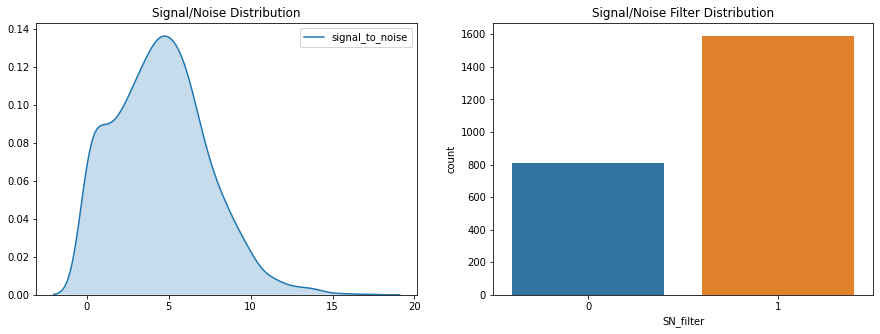

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.kdeplot(train['signal_to_noise'], shade=True, ax=ax[0])
sns.countplot(train['SN_filter'], ax=ax[1])

ax[0].set_title('Signal/Noise Distribution')
ax[1].set_title('Signal/Noise Filter Distribution')

In [30]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [31]:
# We will use this dictionary to map each character to an integer
# so that it can be used as an input in pytorch

token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

In [32]:
print(token2int)

{'(': 0, ')': 1, '.': 2, 'A': 3, 'C': 4, 'G': 5, 'U': 6, 'B': 7, 'E': 8, 'H': 9, 'I': 10, 'M': 11, 'S': 12, 'X': 13}


In [33]:
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
  return np.transpose(np.array(df[cols].applymap(lambda seq: [token2int[x] for x in seq]).values.tolist()), (0,2,1))

In [34]:
train_filtered = train.loc[train.SN_filter==1]
print(train_filtered.shape)
print(train.shape)

(1589, 19)
(2400, 19)


In [35]:
train_inputs = torch.tensor(preprocess_inputs(train_filtered)).to(device)
print(f"Input shape: {train_inputs.shape}")

train_labels = torch.tensor(np.array(train_filtered[target_cols].values.tolist()).transpose(0,2,1))
print(f"Output shape: {train_labels.shape}")

Input shape: torch.Size([1589, 107, 3])
Output shape: torch.Size([1589, 68, 5])


In [36]:
len(token2int)

14

* A model (GRU layer network)
* The dataset (covid)
* An optimizer (Adam)
* A loss (MCRMSELoss)

In [37]:
%%writefile models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialDropout(nn.Dropout2d):
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = super(SpatialDropout, self).forward(x)  
        x = x.permute(0, 2, 1)  
        return x
    

class GRU_model(nn.Module):
    def __init__(self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128, hidden_layers=3):
        super(GRU_model, self).__init__()
        self.pred_len = pred_len

        self.embedding = nn.Embedding(num_embeddings=len(token2int), embedding_dim=embed_dim)
        self.cnn_layer = nn.Conv1d(in_channels=14, out_channels=embed_dim, kernel_size=5, padding=5//2)
        self.embedding_dropout = SpatialDropout(0.3)

        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True
        )

        self.linear = nn.Linear(args.hidden_size * 2, 5)

    def forward(self, seqs):
        seqs = seqs.permute(0, 2, 1)
        embed = self.cnn_layer(seqs)
        embed = self.embedding_dropout(embed)
        reshaped = embed.permute(0, 2, 1) #torch.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
        output, hidden = self.gru(reshaped)
        turncated = output[:, :self.pred_len, :]
        out = self.linear(turncated)
        
        return out

Writing models.py


In [ ]:
FOLDS = 4
EPOCHS = 50
BATCH_SIZE = 64
VERBOSE = 2
LR = 0.01

In [51]:
%%writefile dataset.py
import math, json, gc, random, os, sys, time
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tqdm import tqdm

target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

def prepare_data(df, cols=['sequence', 'structure', 'predicted_loop_type']):
  return np.transpose(np.array(df[cols].applymap(lambda seq: [token2int[x] for x in seq]).values.tolist()), (0,2,1))

  train_filtered = train.loc[train.SN_filter==1]
  print('train_filtered: ', train_filtered.shape)
  print('train:', train.shape)

  train_inputs = torch.tensor(prepare_data(train_filtered)).to(device)
  print(f"Input shape: {train_inputs.shape}")

  train_labels = torch.tensor(np.array(train_filtered[target_cols].values.tolist()).transpose(0,2,1))
  print(f"Output shape: {train_labels.shape}")

  from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)


def train_dataloader(self):
  return DataLoader(self.train_dataset, batch_size=64, shuffle=True)

def val_dataloader(self):
    return DataLoader(self.valid_dataset, batch_size=64, shuffle=False)

def test_dataloader(self):
    pass

Overwriting dataset.py


In [52]:
%%writefile optimizer.py
def configure_optimizers(self):
  optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
  return optimizer

Writing optimizer.py


In [53]:
%%writefile losses.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def rmse(self, y_actual, y_pred):
        mse = self.mse(y_actual, y_pred)
        return torch.sqrt(mse)
    
    def forward(self, y_actual, y_pred, num_scored=None):
        if num_scored == None:
            num_scored = y_actual.shape[-1]
        score = 0
        for i in range(num_scored):
            score += self.rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
        return score

Writing losses.py


In [41]:
# X_train, X_test, y_train, y_test 
#     = train_test_split(X, y, test_size=0.7, random_state=123)

# X_train, X_val, y_train, y_val 
#     = train_test_split(X_train, y_train, test_size=0.5, random_state=123)

In [42]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset, train_lables, test_labels = train_test_split(train_inputs, train_labels, test_size=0.3, random_state=123)
print(train_dataset.shape)
print(test_dataset.shape)
print(train_labels.shape)
print(test_labels.shape)

torch.Size([1112, 107, 3])
torch.Size([477, 107, 3])
torch.Size([1589, 68, 5])
torch.Size([477, 68, 5])


In [44]:
FOLDS = 4
EPOCHS = 50
BATCH_SIZE = 64
VERBOSE = 2
LR = 0.01

In [45]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

kfold = KFold(FOLDS, shuffle=True, random_state=2020)

for k, (train_index, val_index) in enumerate(kfold.split(train_inputs)):
    train_dataset = TensorDataset(train_inputs[train_index], train_labels[train_index])
    val_dataset = TensorDataset(train_inputs[val_index], train_labels[val_index])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [48]:
# print(train_loader.size)
# print(val_loader.size)

In [49]:
# train_dataset, val_dataset, train_lables, val_lables = train_test_split(train_dataset, train_labels, test_size=0.5, random_state=123)

In [ ]:
def train_dataloader(self):
  return DataLoader(self.train_dataset, batch_size=64, shuffle=True)

def val_dataloader(self):
    return DataLoader(self.valid_dataset, batch_size=64, shuffle=False)

def test_dataloader(self):
    return DataLoader(self,mnist_test, batch_size=64)

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms

class LightningMNISTClassifier(pl.LightningModule):

  def prepare_data(self):
    # transforms for images
    transform=transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.1307,), (0.3081,))])
      
    # prepare transforms standard to MNIST
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    
    self.mnist_train, self.mnist_val = random_split(mnist_train, [55000, 5000])

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=64)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=64)

  def test_dataloader(self):
    return DataLoader(self,mnist_test, batch_size=64)

In [ ]:
%%writefile dataset.py

import numpy as np, pandas as pd
import torch, torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

target_col = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

rna_dict    = {x:i for i, x in enumerate('ACGU')} #4
struct_dict = {x:i for i, x in enumerate('().')}  #3
loop_dict   = {x:i for i, x in enumerate('BEHIMSX')}#7

class RNADataset(Dataset):
    def __init__(self, df, augment=None):

        self.rna    = df['sequence'].map(lambda seq: [rna_dict[x] for x in seq])
        self.struct = df['structure'].map(lambda seq: [struct_dict[x] for x in seq])
        self.loop   = df['predicted_loop_type'].map(lambda seq: [loop_dict[x] for x in seq])

        bbp0 =[]
        bbp1 =[]
        id = df.id.values
        # for i in id:
        #     probability = np.load(f'../input/stanford-covid-vaccine/bpps/{i}.npy')
        #     bbp0.append(probability.max(-1).tolist())
        #     bbp1.append((1-probability.sum(-1)).tolist())
        # self.bbp0 = bbp0
        # self.bbp1 = bbp1

        #---
        if 'reactivity' in df.columns:
            target = np.transpose(
                df[target_col]
                .values
                .tolist(),
            (0, 2, 1))
            target = np.ascontiguousarray(target)
        else:
            target = np.zeros((len(df),1,1)) #dummy

        self.df =  df
        self.len = len(self.df)
        self.augment = augment
        self.target = target

    def __str__(self):
        string  = ''
        string += '\tlen  = %d\n'%len(self)
        return string

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        r = self.df.loc[index]
        target = self.target[index]

        rna = np.array(self.rna[index])
        struct = np.array(self.struct[index])
        loop = np.array(self.loop[index])
        # bbp0 = np.array(self.bbp0[index]).reshape(-1,1)
        # bbp1 = np.array(self.bbp1[index]).reshape(-1,1)

        #bbp = np.load(f'../input/stanford-covid-vaccine/bpps/{r.id}.npy')
        #bbp = np.expand_dims(bbp, axis=0)

        seq = np.concatenate([
            np_onehot(rna,4),
            np_onehot(struct,3),
            np_onehot(loop,7),
            # bbp0,
            # bbp1,
        ],1)

        #------
        record = {
            'target': torch.tensor(target, dtype=torch.float),
            #'bbps'  : torch.tensor(bbp, dtype=torch.float),
            'seq' : torch.tensor(seq, dtype=torch.float),
            'ids' : r.id
        }
        if self.augment is not None: record = self.augment(record)
        return record

def np_onehot(x, max=54):
    return np.eye(max)[x]

Writing dataset.py


In [ ]:
%%writefile losses.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def rmse(self, y_actual, y_pred):
        mse = self.mse(y_actual, y_pred)
        return torch.sqrt(mse)
    
    def forward(self, y_actual, y_pred, num_scored=None):
        if num_scored == None:
            num_scored = y_actual.shape[-1]
        score = 0
        for i in range(num_scored):
            score += self.rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
        return score

Writing losses.py


In [ ]:
%%writefile utils.py

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Writing utils.py


In [ ]:
%%writefile train.py

import math, json, gc, random, os, sys, time
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tqdm import tqdm

import models
import losses
from dataset import RNADataset
from utils import AverageMeter
from config import args

## Model
#get comp data
train = pd.read_json('/content/drive/My Drive/Inputs/OpenVaccine/train.json.zip', compression='zip', lines=True)
test = pd.read_json('/content/drive/My Drive/Inputs/OpenVaccine/test.json.zip', compression='zip', lines=True)
sample_sub  = pd.read_csv('/content/drive/My Drive/Inputs/OpenVaccine/sample_submission.csv.zip', compression='zip')

target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

train = train[train.signal_to_noise >= 1]


def train_epcoh(model, loader, optimizer, criterion, device, epoch):
    losses = AverageMeter()

    model.train()
    t = tqdm(loader)
    for i, d in enumerate(t):

        #print(d)

        X = d['seq'].to(device)
        y = d['target'].to(device)

        pred_y = model(X)

        loss = criterion(y, pred_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = X.size(0)
        losses.update(loss.item(), bs)

        t.set_description(f"Train E:{epoch} - Loss:{losses.avg:0.5f}")
    
    t.close()
    return losses.avg

def valid_epoch(model, loader, criterion, device, epoch):
    losses = AverageMeter()

    model.eval()

    with torch.no_grad():
        t = tqdm(loader)
        for i, d in enumerate(t):

            X = d['seq'].to(device)
            y = d['target'].to(device)

            pred_y = model(X)
            
            #print(y.shape, pred_y.shape)
            
            loss = criterion(y, pred_y)

            bs = X.size(0)
            losses.update(loss.item(), bs)

            t.set_description(f"Valid E:{epoch} - Loss:{losses.avg:0.5f}")
        
    t.close()
    return losses.avg

def test_predic(model, loader, device):
    
    outputs_dict = {
        "ids" : [],
        "predicts" : []
    }
    
    model.eval()
    
    with torch.no_grad():
        t = tqdm(loader)
        for i, d in enumerate(t):
            X = d['seq'].float().to(device)
            ids = d['ids']
            
            outs = model(X).cpu().detach().numpy().tolist()
            
            outputs_dict['predicts'].extend(outs)
            outputs_dict['ids'].extend(ids)
            
    return outputs_dict

def main():

    # Setting seed
    seed = args.seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    args.save_path = os.path.join(args.output_dir, args.exp_name)
    os.makedirs(args.save_path, exist_ok=True)

    public_predictions = [] 
    public_ids         = []

    private_predictions = []
    private_ids         = []

    public_df = test.query("seq_length == 107").reset_index(drop=True)
    private_df = test.query("seq_length == 130").reset_index(drop=True)

    public_dataset = RNADataset(public_df)
    private_dataset = RNADataset(private_df)

    public_loader = DataLoader(public_dataset, batch_size=args.batch_size, shuffle=False)
    private_loader = DataLoader(private_dataset, batch_size=args.batch_size, shuffle=False)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    skf = KFold(args.n_folds, shuffle=True, random_state=seed)

    for i, (train_index, valid_index) in enumerate(skf.split(train, train['SN_filter'])):
        print("#"*20)
        print(f"##### Fold : {i}")

        args.fold = i

        train_df = train.iloc[train_index].reset_index(drop=True)
        valid_df = train.iloc[valid_index].reset_index(drop=True)
        
        #valid_df = valid_df[valid_df.SN_filter == 1].reset_index(drop=True)

        train_dataset = RNADataset(train_df)
        valid_dataset = RNADataset(valid_df)

        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False)

        model = models.__dict__[args.network](args, pred_len=68)
        model = model.to(device)

        criterion = losses.__dict__[args.losses]()

        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

        best_loss = 99999

        for epoch in range(args.epochs):

            train_loss = train_epcoh(model, train_loader, optimizer, criterion, device, epoch)
            valid_loss = valid_epoch(model, valid_loader, criterion, device, epoch)

            content = f"""
                {time.ctime()} \n
                Fold:{args.fold}, Epoch:{epoch}, lr:{optimizer.param_groups[0]['lr']:.7}, \n
                Train Loss:{train_loss:0.4f} - Valid Loss:{valid_loss:0.4f} \n
            """
            print(content)

            with open(f'{args.save_path}/log_{args.exp_name}.txt', 'a') as appender:
                appender.write(content + '\n')
            
            if valid_loss < best_loss:
                print(f"######### >>>>>>> Model Improved from {best_loss} -----> {valid_loss}")
                torch.save(model.state_dict(), os.path.join(args.save_path, f"fold-{args.fold}.bin"))
                best_loss = valid_loss
            
            torch.save(model.state_dict(), os.path.join(args.save_path, f"last-fold-{args.fold}.bin"))
            
        public_model = models.__dict__[args.network](args, pred_len=107).to(device)
        public_model.load_state_dict(torch.load(os.path.join(args.save_path, f"fold-{args.fold}.bin")))
        
        private_model = models.__dict__[args.network](args, pred_len=130).to(device)
        private_model.load_state_dict(torch.load(os.path.join(args.save_path, f"fold-{args.fold}.bin")))
        
        public_pred_dict = test_predic(public_model, public_loader, device)
        private_pred_dict = test_predic(private_model, private_loader, device)
        
        public_predictions.append(np.array(public_pred_dict["predicts"]).reshape(629 * 107 , 5))
        private_predictions.append(np.array(private_pred_dict["predicts"]).reshape(3005 * 130, 5))
        
        public_ids.append(public_pred_dict["ids"])
        private_ids.append(private_pred_dict["ids"])

    public_ids1 = [f"{id}_{i}" for id in public_ids[0] for i in range(107)]
    private_ids1 = [f"{id}_{i}" for id in private_ids[0] for i in range(130)]

    public_preds = np.mean(public_predictions, axis=0)
    private_preds = np.mean(private_predictions, axis=0)

    public_pred_df = pd.DataFrame(public_preds, columns=target_cols)
    public_pred_df["id_seqpos"] = public_ids1

    private_pred_df = pd.DataFrame(private_preds, columns=target_cols)
    private_pred_df["id_seqpos"] = private_ids1

    pred_sub_df = public_pred_df.append(private_pred_df)

    pred_sub_df.to_csv(os.path.join(args.save_path, f"{args.sub_name}_submission.csv"), index=False)

if __name__ == "__main__":
    main()

Writing train.py


In [ ]:
%%writefile config.py


class args:
    
    exp_name = "base_model"
    sub_name = ""
    output_dir = "weights"

    network = "GRU_model"

    losses  = "MCRMSELoss"

    
    # Model parameters
    num_embeddings = 14
    embedding_dim  = 128
    hidden_layers  = 3
    hidden_size    = 128
    dropout        = 0.5

    # Training parameters
    lr = 0.0001
    seed = 42
    epochs = 50
    n_folds = 5
    batch_size = 32

Overwriting config.py


In [ ]:
!python3 train.py

####################
##### Fold : 0
Train E:0 - Loss:0.51353: 100% 53/53 [00:02<00:00, 18.49it/s]
Valid E:0 - Loss:0.47443: 100% 14/14 [00:00<00:00, 34.81it/s]

                Thu Sep 24 17:02:09 2020 

                Fold:0, Epoch:0, lr:0.0001, 

                Train Loss:0.5135 - Valid Loss:0.4744 

            
######### >>>>>>> Model Improved from 99999 -----> 0.4744270003977276
Train E:1 - Loss:0.45663: 100% 53/53 [00:02<00:00, 18.84it/s]
Valid E:1 - Loss:0.42892: 100% 14/14 [00:00<00:00, 35.35it/s]

                Thu Sep 24 17:02:12 2020 

                Fold:0, Epoch:1, lr:0.0001, 

                Train Loss:0.4566 - Valid Loss:0.4289 

            
######### >>>>>>> Model Improved from 0.4744270003977276 -----> 0.4289213907150995
Train E:2 - Loss:0.42900: 100% 53/53 [00:02<00:00, 18.79it/s]
Valid E:2 - Loss:0.40639: 100% 14/14 [00:00<00:00, 35.59it/s]

                Thu Sep 24 17:02:15 2020 

                Fold:0, Epoch:2, lr:0.0001, 

                Train Loss:0.42